# DoorDash ETA Prediction

## Overview
The dataset used for this project is sourced from DoorDash deliveries in early 2015, capturing the details of various orders in a subset of cities. The primary goal of this analysis is to predict the estimated time taken for delivery, measured in total seconds from when an order is placed (`created_at`) to when it is delivered (`actual_delivery_time`). This prediction is crucial for improving customer experience on the DoorDash platform.

## Data Description
The dataset is provided in a CSV file called `historical_data.csv` and includes several columns representing different aspects of each delivery.

### Columns in the Dataset:
1. **Time Features:**
   - `market_id`: Identifier for the city/region (e.g., Los Angeles).
   - `created_at`: Timestamp in UTC when the order was submitted.
   - `actual_delivery_time`: Timestamp in UTC when the order was delivered.

2. **Store Features:**
   - `store_id`: Identifier for the restaurant where the order was placed.
   - `store_primary_category`: Cuisine category of the restaurant (e.g., Italian, Asian).
   - `order_protocol`: An identifier denoting the order mode used by the store.

3. **Order Features:**
   - `total_items`: Total number of items in the order.
   - `subtotal`: Total value of the order (in cents).
   - `num_distinct_items`: Number of unique items in the order.
   - `min_item_price`: Price of the cheapest item (in cents).
   - `max_item_price`: Price of the most expensive item (in cents).

4. **Market Features:**
   - `total_onshift_dashers`: Number of available delivery drivers within 10 miles of the store at the time of order.
   - `total_busy_dashers`: Number of those drivers who are currently occupied with an order.
   - `total_outstanding_orders`: Number of orders being processed within 10 miles of the current order.

5. **Predictions from Other Models:**
   - `estimated_order_place_duration`: Estimated time for the restaurant to receive the order (in seconds).
   - `estimated_store_to_consumer_driving_duration`: Estimated travel time between the store and the consumer (in seconds).

## Data Characteristics
- **Unit of Time**: All time values are recorded in seconds.
- **Monetary Values**: Dollar amounts are expressed in cents.
- **Time Zones**: The timestamps are given in UTC, with the relevant timezone being US/Pacific.

## Objective
The aim of this analysis is to develop a model that accurately predicts the delivery duration, helping DoorDash enhance service quality and meet consumer expectations more effectively.


### Import Necessary Libraries

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_csv("/kaggle/input/doordash-eta-prediction/historical_data.csv")

In [3]:
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [5]:
data.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
count,196441.000000,197428.000000,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000
mean,2.978706,3530.510272,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,308.560179,545.358935
std,1.524867,2053.496711,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,90.139653,219.352902
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000
25%,2.000000,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000
50%,3.000000,3592.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000
75%,4.000000,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000


### Convert and Extract Datetime Features

In [6]:
# Convert datetime columns
data['created_at'] = pd.to_datetime(data['created_at'])
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])
data['delivery_duration_minutes'] = (
    (data['actual_delivery_time'] - data['created_at']).dt.total_seconds() / 60
)

# Time-Based Features
data['hour'] = data['created_at'].dt.hour
data['day_of_week_num'] = data['created_at'].dt.dayofweek
data['is_weekend'] = data['day_of_week_num'].isin([5, 6]).astype(int)

# Holiday Indicator
us_holidays = holidays.US()
data['is_holiday'] = data['created_at'].dt.date.astype(str).isin(us_holidays).astype(int)

### Datetime Conversion
- **`created_at` and `actual_delivery_time`**: Converts string datetime columns into `datetime` type, enabling easy extraction of date-related features.

### Target Variable
- **`delivery_duration_minutes`**: Calculates the target variable, representing the delivery time in minutes. This is essential for model training to predict delivery times.

### Time-Based Features
- **`hour`**: Helps the model learn hourly patterns in delivery times.
- **`day_of_week_num`**: Allows the model to capture trends based on the day of the week.
- **`is_weekend`**: Indicates whether the delivery was on a weekend, helping the model understand delivery time variations during weekends.

### Holiday Indicator
- **`is_holiday`**: Marks whether the delivery occurred on a holiday, which can impact delivery times due to reduced availability or increased demand.

## Dasher Features

In [7]:
data['total_busy_dashers'] = abs(data['total_busy_dashers'])  # Handle negative values
data['total_onshift_dashers'] = abs(data['total_onshift_dashers'])
data['dashers_per_order'] = data['total_onshift_dashers'] / (data['total_outstanding_orders'] + 1e-5)
data['%_dashers_avail'] = data['total_busy_dashers'] / (
    data['total_busy_dashers'] + data['total_onshift_dashers'] + 1e-5
)

- **`total_busy_dashers`**: Ensures non-negative values for better modeling and reflects available resources.
- **`total_onshift_dashers`**: Ensures non-negative values, representing the total number of dashers working.
- **`dashers_per_order`**: Calculates the ratio of dashers to outstanding orders, helping the model understand how resource availability affects delivery time.
- **`%_dashers_avail`**: Represents the proportion of busy dashers compared to the total, providing insight into overall availability.

## Price-Based Features

In [8]:
data['price_range'] = data['max_item_price'] - data['min_item_price']
data['avg_item_price'] = data['subtotal'] / (data['total_items'] + 1e-5)
data['price_volatility'] = data['price_range'] / (data['avg_item_price'] + 1e-5)

- **`price_range`**: Measures the difference between the highest and lowest item prices, giving insight into price volatility.
- **`avg_item_price`**: Calculates the average item price per order, contributing to understanding how item pricing may affect delivery.
- **`price_volatility`**: Shows the variability in price within an order, indicating potential impacts on order handling and delivery times.

## Interaction Features

In [9]:
# Interaction Features
data['order_intensity'] = data['total_outstanding_orders'] / (data['total_busy_dashers'] + 1e-5)
data['delivery_difficulty'] = data['order_intensity'] * data['estimated_store_to_consumer_driving_duration']

- **`order_intensity`**: Represents the ratio of total outstanding orders to busy dashers, providing an indication of workload and potential delivery time impacts.
- **`delivery_difficulty`**: The interaction of order intensity and delivery duration, capturing how workload complexity impacts delivery times.

## Delivery Speed

In [10]:
data['historical_avg_delivery_time'] = data.groupby(
    ['store_id', 'hour'])['delivery_duration_minutes'].transform('mean')

data['delivery_speed'] = data['historical_avg_delivery_time'] / (
    data['estimated_store_to_consumer_driving_duration'] / 60 + 1e-5)


- **`delivery_speed`**: Measures the ratio of delivery duration to estimated store-to-consumer driving duration, indicating how efficiently deliveries are made.
- Im using proxy feature to indirectly use the target to avoid data leakage as historical avg delivery time

## Log Transformations

In [11]:
data['log_subtotal'] = np.log1p(data['subtotal'])
data['log_outstanding_orders'] = np.log1p(data['total_outstanding_orders'].clip(lower=1e-5))

- **`log_subtotal`**: Applies a log transformation to the subtotal for better handling of skewed data and reducing the impact of outliers.
- **`log_outstanding_orders`**: Applies a log transformation to the number of outstanding orders, ensuring a better scale and reducing data skew.


In [12]:
data = data.drop(columns=['created_at', 'actual_delivery_time'])

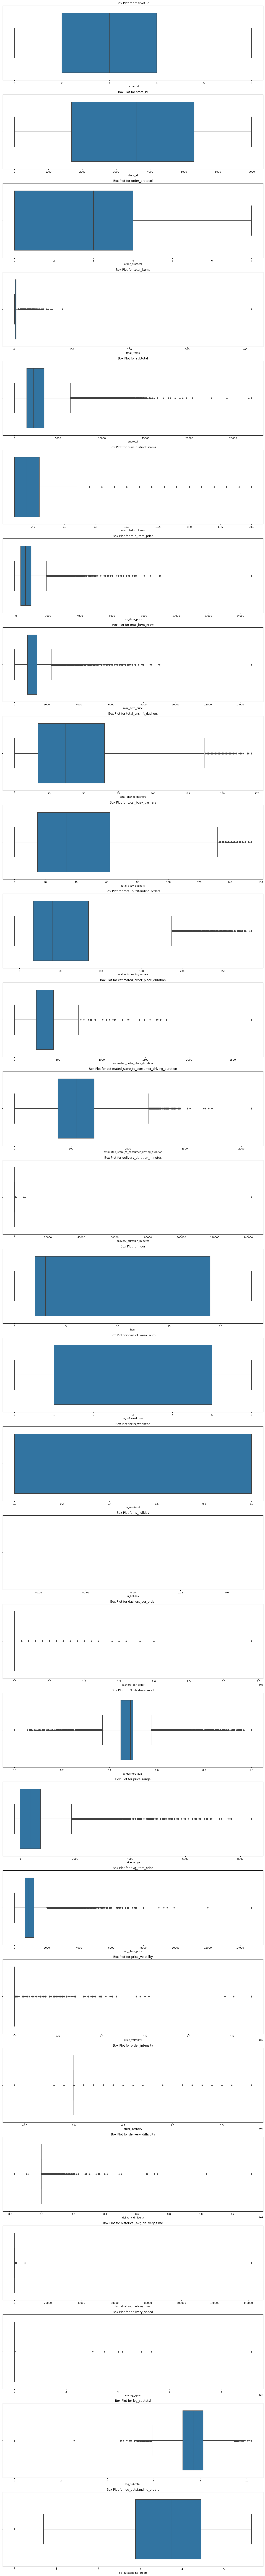

In [13]:
# Plot box plots for all numerical columns
def plot_outliers_all_numerical(data):
    numerical_cols = data.select_dtypes(include=['number']).columns
    num_cols = len(numerical_cols)
    
    # Set up the matplotlib figure
    plt.figure(figsize=(15, 5 * num_cols))
    
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(num_cols, 1, i)
        sns.boxplot(x=data[col])
        plt.title(f'Box Plot for {col}')
        plt.xlabel(col)
    
    plt.tight_layout()
    plt.show()

plot_outliers_all_numerical(data)


# Outlier Removal Using IQR Method

In [14]:
def remove_outliers_iqr(df, variables, threshold=1.5):
   
    for variable in variables:
        if variable in df.columns:
            Q1 = df[variable].quantile(0.25)
            Q3 = df[variable].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - (threshold * IQR)
            upper_bound = Q3 + (threshold * IQR)
            df = df[(df[variable] >= lower_bound) & (df[variable] <= upper_bound)]
    return df

# Define numerical columns with potential outliers
outlier_columns = [
    'subtotal', 'delivery_duration_minutes', 'max_item_price', 'price_range',
    'avg_item_price', 'price_volatility', 'delivery_speed'
]

# Remove outliers
data = remove_outliers_iqr(data, outlier_columns)



## Columns Processed
The following numerical columns are targeted for outlier removal:
- `subtotal`: The total value of items in an order.
- `delivery_duration_minutes`: The total delivery time in minutes.
- `max_item_price`: The highest item price in an order.
- `price_range`: The difference between the maximum and minimum item prices.
- `avg_item_price`: The average price of items in an order.
- `price_volatility`: The variability of item prices.
- `delivery_speed`: The ratio of delivery duration to estimated driving duration.
          

# Handling Missing Values in the Dataset
### Using KNN Imputer


In [15]:
def handle_missing_values(df, n_neighbors=5):
    
    # Handle numerical columns using KNN Imputer
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    
    # Handle categorical columns using mode imputation
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    return df

# Apply missing value handling
data = handle_missing_values(data)
print("Missing values per column after imputation:")
print(data.isnull().sum())


Missing values per column after imputation:
market_id                                       0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
delivery_duration_minutes                       0
hour                                            0
day_of_week_num                                 0
is_weekend                                      0
is_holiday                                      0
dasher

### 1. Numerical Columns:
- **KNN Imputer**: Uses the k-nearest neighbors algorithm to estimate missing values based on the similarity to other rows. The number of neighbors (`n_neighbors`) can be adjusted to control the influence of nearby data points.

### 2. Categorical Columns:
- **Mode Imputation**: Fills missing values with the most frequent value (mode) of the column. This ensures that categorical columns retain the most common category, maintaining the overall distribution.

In [16]:
#This Method requires less computation power but not much reliable in outier data(we consider this when we require the outliers fix in less time)

'''def handle_missing_values(df):
    # Handle numerical columns using median imputation for efficiency
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        df[col].fillna(df[col].median(), inplace=True)
    
    # Handle categorical columns using mode imputation
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    
    return df'''

"def handle_missing_values(df):\n    # Handle numerical columns using median imputation for efficiency\n    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns\n    for col in numeric_cols:\n        df[col].fillna(df[col].median(), inplace=True)\n    \n    # Handle categorical columns using mode imputation\n    categorical_cols = df.select_dtypes(include=['object', 'category']).columns\n    for col in categorical_cols:\n        df[col].fillna(df[col].mode()[0], inplace=True)\n    \n    return df"

# Optimized Label Encoding for Categorical Columns

In [17]:
def optimized_label_encoding(df, cat_cols):
    le_dict = {} 
    
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        le_dict[col] = le 
    
    return df, le_dict
    
categorical_columns = ['store_primary_category']
data, encoders = optimized_label_encoding(data, categorical_columns)

data['store_primary_category'].unique()

array([ 4, 46, 35, 38, 58, 68, 15, 55, 20, 60, 13, 10, 45, 39, 18, 28, 33,
       50, 40, 70,  6,  7, 27, 59, 72, 22, 65, 16, 23, 62, 71, 57, 53, 66,
       42, 34, 11, 49, 52,  2, 24, 61, 54, 69, 44, 25, 47,  0, 12, 31, 29,
       17, 21, 32, 30, 14, 48, 51, 64, 63, 67, 56,  9, 26, 19,  1,  5, 37,
       43, 41,  8, 36,  3])

Label encoding is used to convert categorical values into numeric values so that machine learning algorithms can process them efficiently.
It is not fit for nominal values but instead of using OneHot Encoder which cause enormous amount of columns or like Target encoder may cause to a data leak, it is better in this way.

- The function iterates over the specified columns (`cat_cols`), fits the encoder on each column, and transforms the column values accordingly.
- The encoder for each column is stored in a dictionary (`le_dict`) for potential future use


In [18]:
# Target and feature variables
X = data.drop(columns=['delivery_duration_minutes'])
y = data['delivery_duration_minutes']

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Linear Regression Model for Predicting Delivery Duration

In [20]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Evaluate the model using MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 8.11
Root Mean Squared Error (RMSE): 10.52


# LightGBM Model for Predicting Delivery Duration

In [21]:
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    num_leaves=31,
    learning_rate=0.1,
    n_estimators=200,
    random_state=42
)

lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)

# Evaluate the model using MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5058
[LightGBM] [Info] Number of data points in the train set: 125315, number of used features: 28
[LightGBM] [Info] Start training from score 45.038075
Mean Absolute Error (MAE): 7.82
Root Mean Squared Error (RMSE): 10.16


# Neural Network Model for Predicting Delivery Duration

In [22]:
neural_model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.2),  
    Dense(64, activation='relu'),
    Dropout(0.2), 
    Dense(32, activation='relu'),  
    Dense(1, activation='linear')
])

# Compile the model
neural_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=10,  
    restore_best_weights=True  
)

# Train the model
history = neural_model.fit(
    X_train, y_train,
    validation_split=0.2,  
    epochs=50,  
    batch_size=32, 
    callbacks=[early_stopping]  
)

# Step 7: Model Evaluation
y_pred = neural_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


I0000 00:00:1745254838.989267     103 service.cc:145] XLA service 0x7cb168004a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745254838.989319     103 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 109/3133 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1744.4613 - mae: 37.8550  

I0000 00:00:1745254842.243159     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3133/3133 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 322.5022 - mae: 12.5325 - val_loss: 116.1028 - val_mae: 8.2099
Epoch 2/50
3133/3133 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 131.1428 - mae: 8.8052 - val_loss: 116.2686 - val_mae: 8.1702
Epoch 3/50
3133/3133 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 126.1559 - mae: 8.6442 - val_loss: 110.6668 - val_mae: 8.0162
Epoch 4/50
3133/3133 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 123.9871 - mae: 8.5884 - val_loss: 113.4745 - val_mae: 8.0838
Epoch 5/50
3133/3133 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 120.0910 - mae: 8.4347 - val_loss: 108.4894 - val_mae: 8.0319
Epoch 6/50
3133/3133 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 118.2985 - mae: 8.3666 - val_loss: 108.4376 - val_mae: 8.0071
Epoch 7/50
3133/3133 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 116.6904 - mae: 8.2802 - val_loss: 108.7081 - val_mae: 7.9799
Epoch 8/50
3133/3133 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 115.1684 - mae: 8.2691 - val_loss: 108.8966 - val_mae: 7.9985
Epoch 9/50
3133/3

# Random Forest Model for Predicting Delivery Duration

In [24]:
# Define the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42
)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model using MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 8.02
Root Mean Squared Error (RMSE): 10.40


In [26]:
import time
from numba import njit, prange

In [29]:
# Sklearn
start = time.time()
mae_sklearn = mean_absolute_error(y_test, y_pred)
rmse_sklearn = np.sqrt(mean_squared_error(y_test, y_pred))
t_sklearn = time.time() - start
print(f"[Sklearn]   MAE: {mae_sklearn:.4f}  RMSE: {rmse_sklearn:.4f}  Time: {t_sklearn:.4f} sec")

# Numba
@njit(parallel=True)
def mae_numba(y_true, y_pred):
    error = 0.0
    for i in prange(len(y_true)):
        error += abs(y_true[i] - y_pred[i])
    return error / len(y_true)

@njit(parallel=True)
def rmse_numba(y_true, y_pred):
    total = 0.0
    for i in prange(len(y_true)):
        diff = y_true[i] - y_pred[i]
        total += diff * diff
    return np.sqrt(total / len(y_true))

start = time.time()
mae_n = mae_numba(y_test.values, y_pred)
rmse_n = rmse_numba(y_test.values, y_pred)
t_numba = time.time() - start
print(f"[Numba]     MAE: {mae_n:.4f}  RMSE: {rmse_n:.4f}  Time: {t_numba:.4f} sec")

print("Results match:", np.allclose(mae_sklearn, mae_n), np.allclose(rmse_sklearn, rmse_n))

[Sklearn]   MAE: 8.0174  RMSE: 10.3989  Time: 0.0031 sec
[Numba]     MAE: 8.0174  RMSE: 10.3989  Time: 0.8569 sec
Results match: True True


In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from joblib import Parallel, delayed
import numpy as np
import time

# Assumes the following data already exists:
# X_train, X_test, y_train, y_test

# Function to train and evaluate a single Random Forest model
def train_rf(X_train, y_train, X_test, y_test, seed):
    model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=seed)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return {"seed": seed, "mae": mae, "rmse": rmse}

seeds = [0, 1, 2]

# ✅ Parallel training using joblib
start_parallel = time.time()
results_parallel = Parallel(n_jobs=3)(
    delayed(train_rf)(X_train, y_train, X_test, y_test, seed) for seed in seeds
)
time_parallel = time.time() - start_parallel

# ✅ Sequential training using a regular for-loop
start_sequential = time.time()
results_sequential = []
for seed in seeds:
    results_sequential.append(train_rf(X_train, y_train, X_test, y_test, seed))
time_sequential = time.time() - start_sequential

# ✅ Output results for comparison
print("==== Parallel (n_jobs=3) ====")
for r in results_parallel:
    print(f"Seed: {r['seed']}  MAE: {r['mae']:.4f}  RMSE: {r['rmse']:.4f}")
print(f"Total time: {time_parallel:.2f} seconds\n")

print("==== Sequential (for-loop) ====")
for r in results_sequential:
    print(f"Seed: {r['seed']}  MAE: {r['mae']:.4f}  RMSE: {r['rmse']:.4f}")
print(f"Total time: {time_sequential:.2f} seconds")


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


==== Parallel (n_jobs=3) ====
Seed: 0  MAE: 8.0337  RMSE: 10.4160
Seed: 1  MAE: 8.0336  RMSE: 10.4184
Seed: 2  MAE: 8.0458  RMSE: 10.4334
Total time: 288.54 seconds

==== Sequential (for-loop) ====
Seed: 0  MAE: 8.0337  RMSE: 10.4160
Seed: 1  MAE: 8.0336  RMSE: 10.4184
Seed: 2  MAE: 8.0458  RMSE: 10.4334
Total time: 275.71 seconds


In [31]:
import time
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ------- Version 1: n_jobs=None -------
start_time = time.time()

rf_model_single = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=None  # default: single thread
)

rf_model_single.fit(X_train, y_train)
y_pred_single = rf_model_single.predict(X_test)

time_single = time.time() - start_time
mae_single = mean_absolute_error(y_test, y_pred_single)
rmse_single = np.sqrt(mean_squared_error(y_test, y_pred_single))

print("=== Random Forest (n_jobs=None) ===")
print(f"Training Time: {time_single:.2f} seconds")
print(f"MAE: {mae_single:.2f}")
print(f"RMSE: {rmse_single:.2f}\n")


# ------- Version 2: n_jobs=-1 -------
start_time = time.time()

rf_model_parallel = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1  # all available cores
)

rf_model_parallel.fit(X_train, y_train)
y_pred_parallel = rf_model_parallel.predict(X_test)

time_parallel = time.time() - start_time
mae_parallel = mean_absolute_error(y_test, y_pred_parallel)
rmse_parallel = np.sqrt(mean_squared_error(y_test, y_pred_parallel))

print("=== Random Forest (n_jobs=-1) ===")
print(f"Training Time: {time_parallel:.2f} seconds")
print(f"MAE: {mae_parallel:.2f}")
print(f"RMSE: {rmse_parallel:.2f}")

=== Random Forest (n_jobs=None) ===
Training Time: 250.53 seconds
MAE: 8.03
RMSE: 10.42

=== Random Forest (n_jobs=-1) ===
Training Time: 91.79 seconds
MAE: 8.03
RMSE: 10.42


# Conclusion

## Summary of Analysis
The DoorDash ETA prediction dataset offers valuable insights into factors influencing delivery times, capturing essential details from order placement to final delivery. Key variables impacting delivery durations include time-based features, store and market conditions, and order characteristics. Notably, the number of available dashers and their status, the number of items in the order, and store type are significant contributors to delivery time.

## Key Findings
- **Temporal Patterns**: Delivery times are influenced by the time of order creation and market congestion. Higher numbers of outstanding orders and active dashers correlate with longer delivery times.
- **Order Complexity**: Larger orders with more items and higher total subtotals generally lead to longer delivery times.
- **Store Influence**: The type of store and dasher availability in its vicinity affect delivery speed, suggesting that optimizing dasher distribution relative to store location and order volume can improve efficiency.
- **Model Performance**: Predictive features such as `estimated_order_place_duration` and `estimated_store_to_consumer_driving_duration` can be used effectively for accurate ETA predictions.

## Model Performance Summary

## Model Performance Overview

| **Model**          | **MAE (minutes)** | **RMSE (minutes)** |
|--------------------|--------------------|---------------------|
| **LightGBM**       | 7.82               | 10.16               |
| **Neural Network** | 7.99               | 10.40               |
| **Linear Regression** | 8.11            | 10.52             |
                    |
## Analysis and Recomme

### 1. LightGBM Model
- **Best Performance**: LightGBM showed the highest accuracy with an MAE **7.82** and an RMSE **10.16**, demonstrating its capability to handle complex relationships in the data effectively.
- **Implications**: LightGBM is the ideal model for ETA predictions due to its accuracy and efficiency with large datasets. Further optimization through hyperparameter tuning and feature engineering can improve results even more.

### 2. Neural Network Model
- **Moderate Performance**: The neural network had an MAE of **7.99** and an RMSE of **10.40**, which is better than linear regression but not as effective as LightGBM.
- **Implications**: While neural networks can model complex data, their performance here suggests that they need more tuning and training adjustments to match or exceed LightGBM.

### 3. Linear Regression Model
- **Weakest Performance**: The linear regression model had an MAE of **8.11** and an RMSE of **10.52**, indicating it cannot capture the data's complexities adequately.
- **Implications**: Linear regression may be used for initial benchmarks or when interpretability is prioritized over predictive aracy.
ctiv
g Delivery Times

### Key Factors Affecting Delivery Time
- **Time-Based Features**: Delivery times are significantly affected by the time of order placement and time of day.
- **Geographical and Traffic Conditions**: Locations and traffic influence delivery speed.
- **Order Size and Complexity**: Larger or more complex orders take longer to handle.
- **External Conditions**: Weather and unforeseen events can also impact delivery times.

### Suggested Improvements for Business Optimization and Enhanced Model Performance

1. **Integrate Real-Time Data**: Utilize APIs for live traffic, weather, and event updates to dynamically adjust ETAs.
2. **Peak Time Analysis**: Identify and manage peak hours by adjusting scheduling to minimize delays.
3. **Advanced Routing**: Implement route optimization algorithms considering real-time conditions.
4. **Data Enrichment**: Include more detailed location and external factors like traffic congestion.
5. **Feature Engineering**: Develop new features representing traffic congestion patterns and seasonal variations.
6. **Automated Adjustments**: Train models on historical data with traffic and weather as features to adapt to real-time conditions.
7. **Feedback Loops**: Regularly compare actual delivery times with predictions to refine the model.

### Data Enhancements
- **Expand Feature Set**: Add variables such as driver experience and order priority.
- **Ensure Data Quality**: Validate data accuracy for consistency in time, distance, and delivery details.
- **Reduce Noise**: Apply data cleaning techniques to minimize anomalies and ensure a realistic dataset.

### Future Model Enhancements
- **Hyperparameter Tuning**: Optimize LightGBM parameters using grid search or Bayesian methods.
- **Ensemble Methods**: Combine strengths of LightGBM, neural networks, and linear regression for a robust solution.
- **Continuous Updates**: Regularly refresh training data to adapt to changes in delivery patterns, traffic, and weather.

## Final Thoughts
Understanding the factors impacting delivery times enables DoorDash to take proactive measures that enhance delivery efficiency and customer experience. Implementing the strategies discussed can lead to more accurate ETAs and optimized resource allocation, ultimately improving service quality on the platform.
